Imports

In [ ]:
from analysis_script import *
from sklearn.linear_model import LogisticRegression, LinearRegression
from causallib.estimation import IPW, MarginalOutcomeEstimator, Matching
from bicause_tree import BICauseTree, crump

Model and hyperparameters configuration

In [ ]:
dataset = 'twins'
file_name =None
run_multiprocessing = False

data, x, t, y = get_data(dataset)
n_bootstraps = 50
test_size = 0.5
multiple_hypothesis_test_method = 'holm'
positivity_filtering_method = crump
positivity_filtering_kwargs = {}


models_to_compare = {
            "BICauseTree(IPW)": BICauseTree(min_treat_group_size=2, asmd_threshold_split=0.1, max_depth = 10, individual=False,
                                multiple_hypothesis_test_alpha=0.05,
                                multiple_hypothesis_test_method=multiple_hypothesis_test_method,
                                positivity_filtering_method=positivity_filtering_method,
                                positivity_filtering_kwargs=positivity_filtering_kwargs,
                                outcome_model=IPW(LogisticRegression(solver='saga', penalty='none', max_iter=500))
                                ),
            "BICauseTree(Marginal)": BICauseTree(min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
                                          individual=False,
                                          multiple_hypothesis_test_alpha=0.05,
                                          multiple_hypothesis_test_method=multiple_hypothesis_test_method,
                                          positivity_filtering_method=positivity_filtering_method,
                                          positivity_filtering_kwargs=positivity_filtering_kwargs,
                                          outcome_model=MarginalOutcomeEstimator(learner=None)
                                          ),
            "Matching": Matching(propensity_transform=None, caliper=None, with_replacement=True, n_neighbors=1,
                                 matching_mode="both", metric="mahalanobis", knn_backend="sklearn",
                                 estimate_observed_outcome=False),
            "Ground truth": (data['y1'], data['y0']),
            "IPW": IPW(LogisticRegression(solver='saga', penalty='none', max_iter=500)),
            "Marginal": MarginalOutcomeEstimator(learner=None)}

# Note: Causal Tree and Causal Forest are not implemented here as their API differs
# You may generate a nested list of ATE for the different bootstraps using the econml package
# with the following code for the models:
# from econml.dml import CausalForestDML
# 'Causal Tree': dml.CausalForestDML(n_estimators=50, inference=False)
# 'Causal Forest': dml.CausalForestDML(n_estimators=1, subforest_size=1, inference=False)

outcome_names = ['BICauseTree(IPW)', 'BICauseTree(Marginal)', 'Matching']
tree_names = ['BICauseTree(IPW)', 'BICauseTree(Marginal)']
pscore_names = ['BICauseTree(Marginal)', 'BICauseTree(IPW)', 'IPW']
tree_filter_name = ['BICauseTree(Marginal)']


Model fitting

In [ ]:
effects, fitted_models, bootstrap_matrix = bootstrap_fit_effect(models_to_compare, x, t, y, tree_names,
                         n_bootstraps=n_bootstraps, test_size=test_size, run_multiprocessing=run_multiprocessing)

pscore_fitted_models = {id: model for id, model in fitted_models.items() if id[0] in pscore_names}
outcome_fitted_models = {id: model for id, model in fitted_models.items() if id[0] in outcome_names}
tree_fitted_models = {id: model for id, model in fitted_models.items() if id[0] in tree_names}
tree_unfitted_models = {id: model for id, model in models_to_compare.items() if id in tree_names}
filtering_tree_models = {id: model for id, model in fitted_models.items() if id[0] in tree_filter_name}

if positivity_filtering_method is not None:
    positivity_matrix = generate_violating_matrix(filtering_tree_models, x)
else:
    positivity_matrix = pd.DataFrame(data=np.ones((len(x), len(filtering_tree_models))), index=x.index)
# positivity_matrix has non violating samples as 1 rest 0

positivity_boot_mask = np.multiply(bootstrap_matrix, positivity_matrix)
# positivity_boot_mask hqs test & non violating samples marked as 1 rest 0

Comparing effect estimation biases across models 

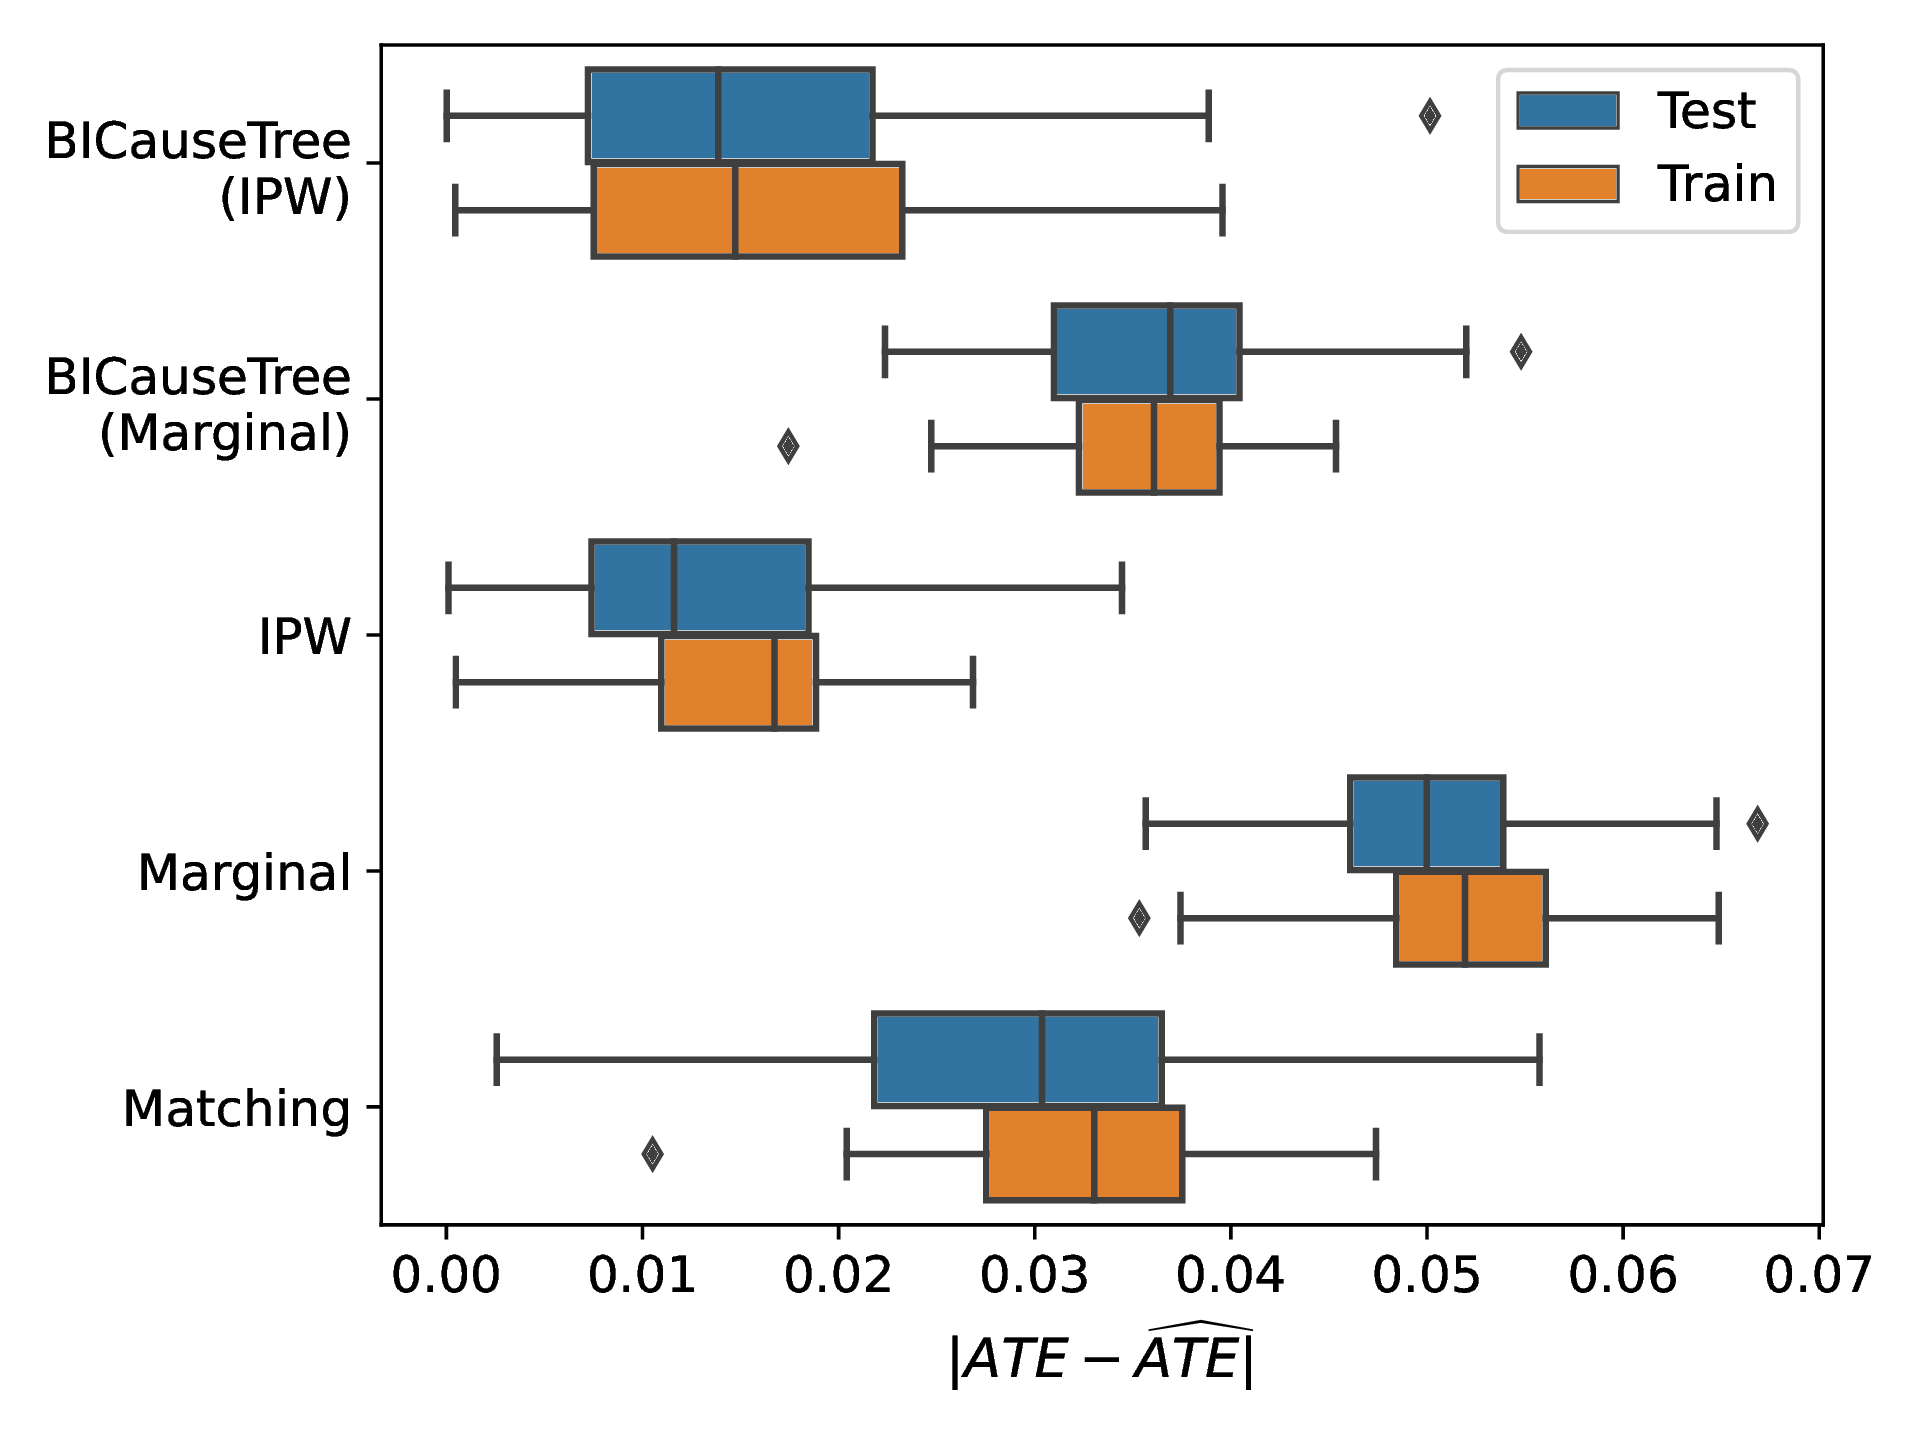

In [40]:
filtered_effects = compute_filtered_effect(x, t, y, bootstrap_matrix, positivity_matrix, fitted_models, models_to_compare)
filtered_effect_diff_plot = box_plot_effect_difference(models_to_compare, filtered_effects, plot_test=True,
                                                       path=None)

Propensity score estimation: calibration

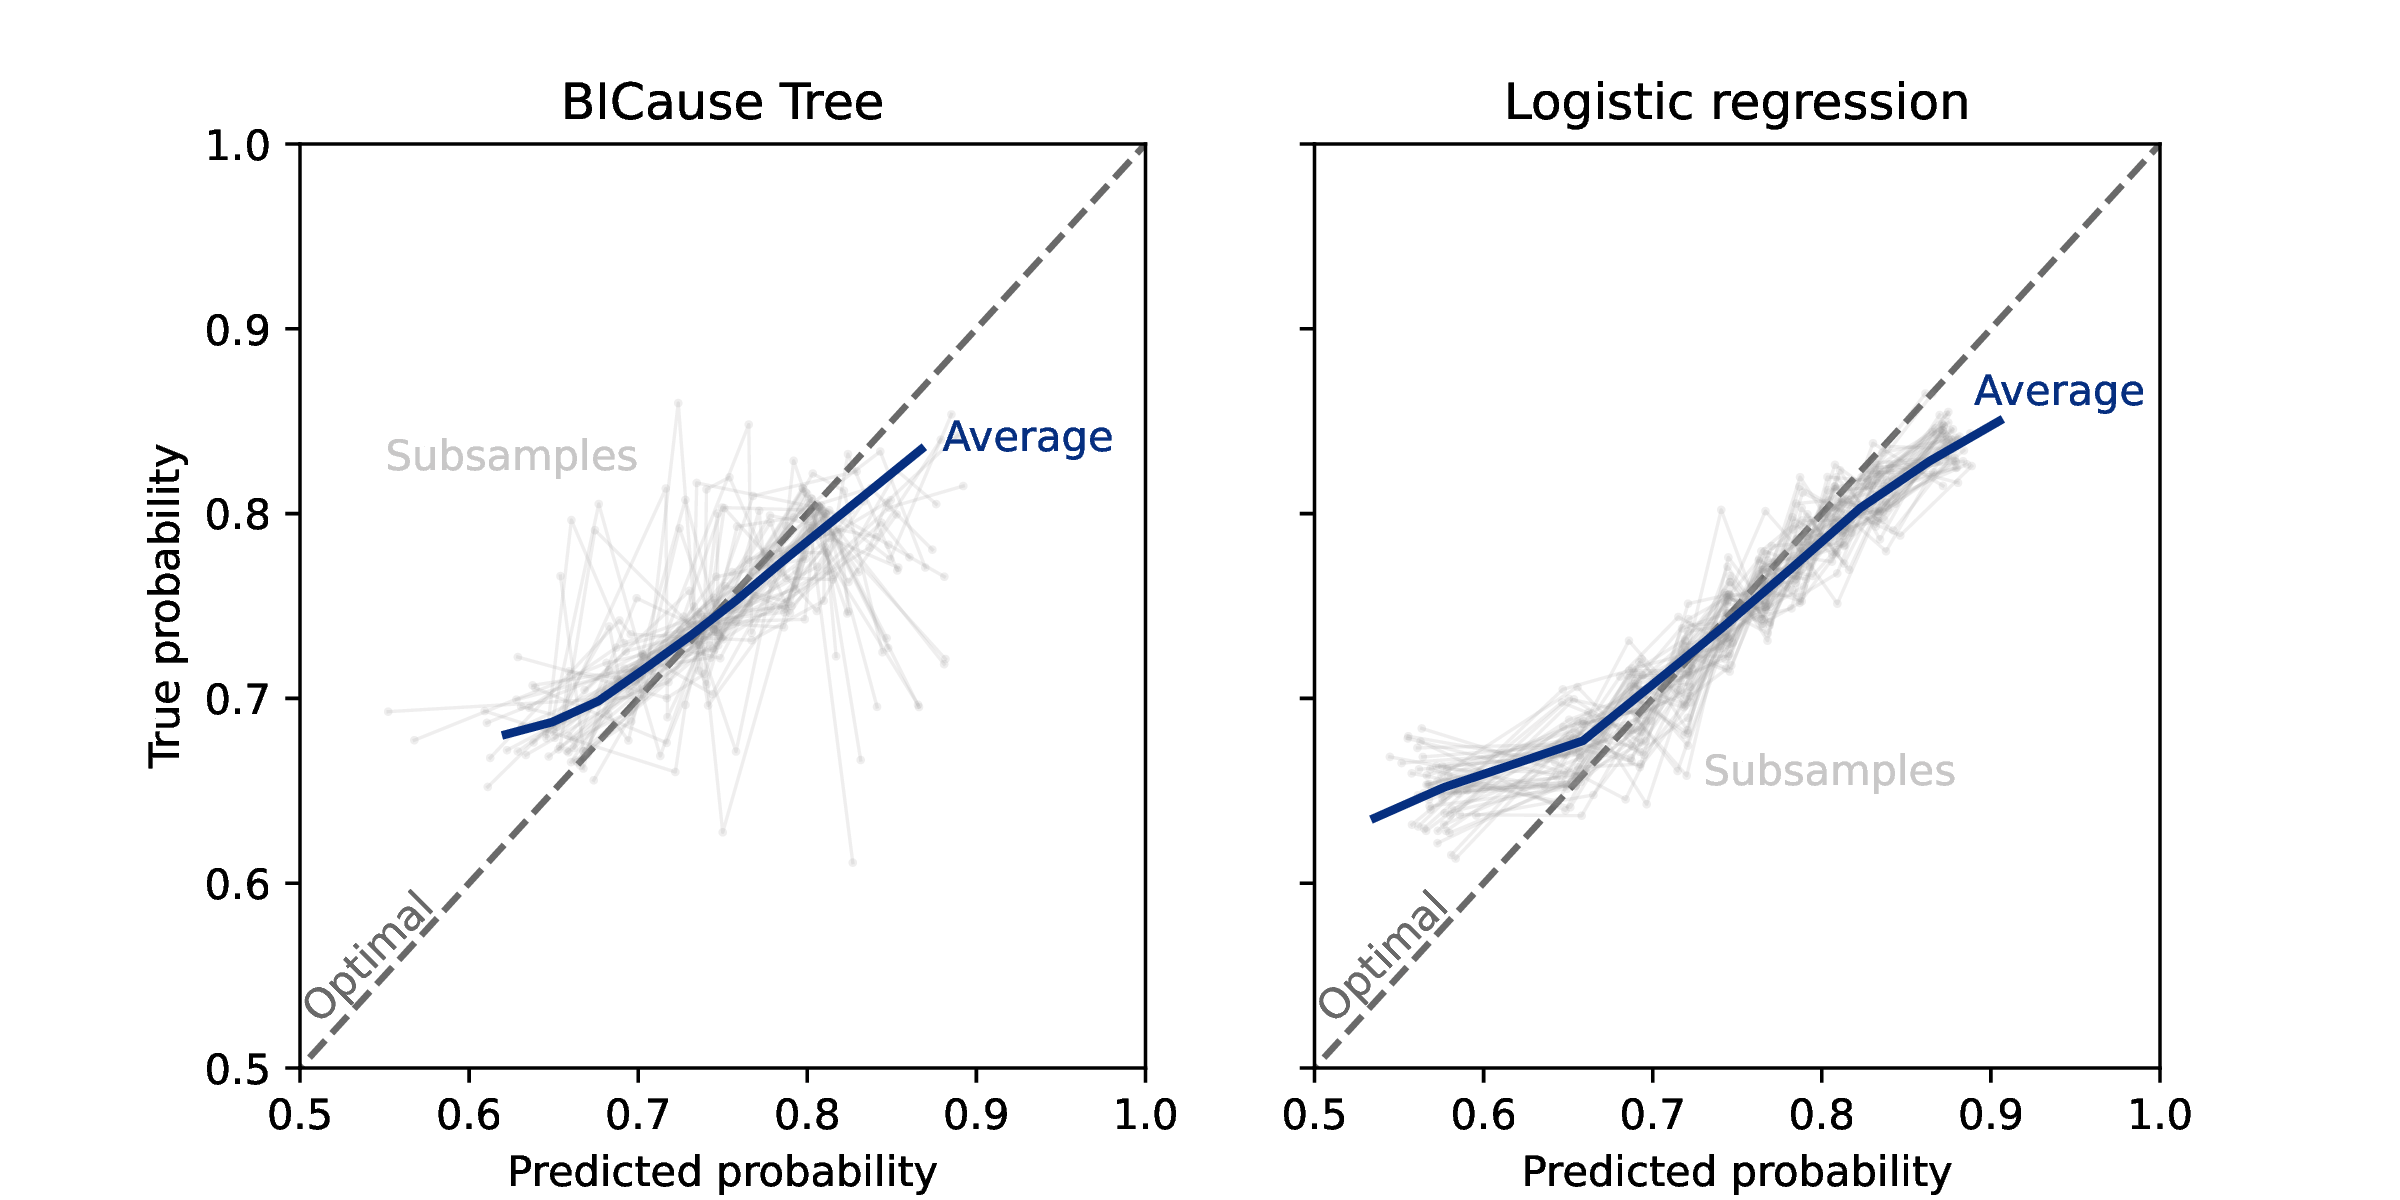

In [39]:
bootstrap_pscores = get_pscores(x, bootstrap_matrix, pscore_fitted_models)
filtered_bootstrap_pscores = filter_results_by_positivity_violation(positivity_boot_mask, bootstrap_pscores)
avg_smoothed_calibration_curves_ps, calibration_curves_ps = generate_calibration_data2(filtered_bootstrap_pscores, t, 'propensity_score', t=None, n_bins=10)
fig_pscore = plot_calibration_curve_2(avg_smoothed_calibration_curves_ps, calibration_curves_ps, use_legend=True)

Outcome estimation: calibration

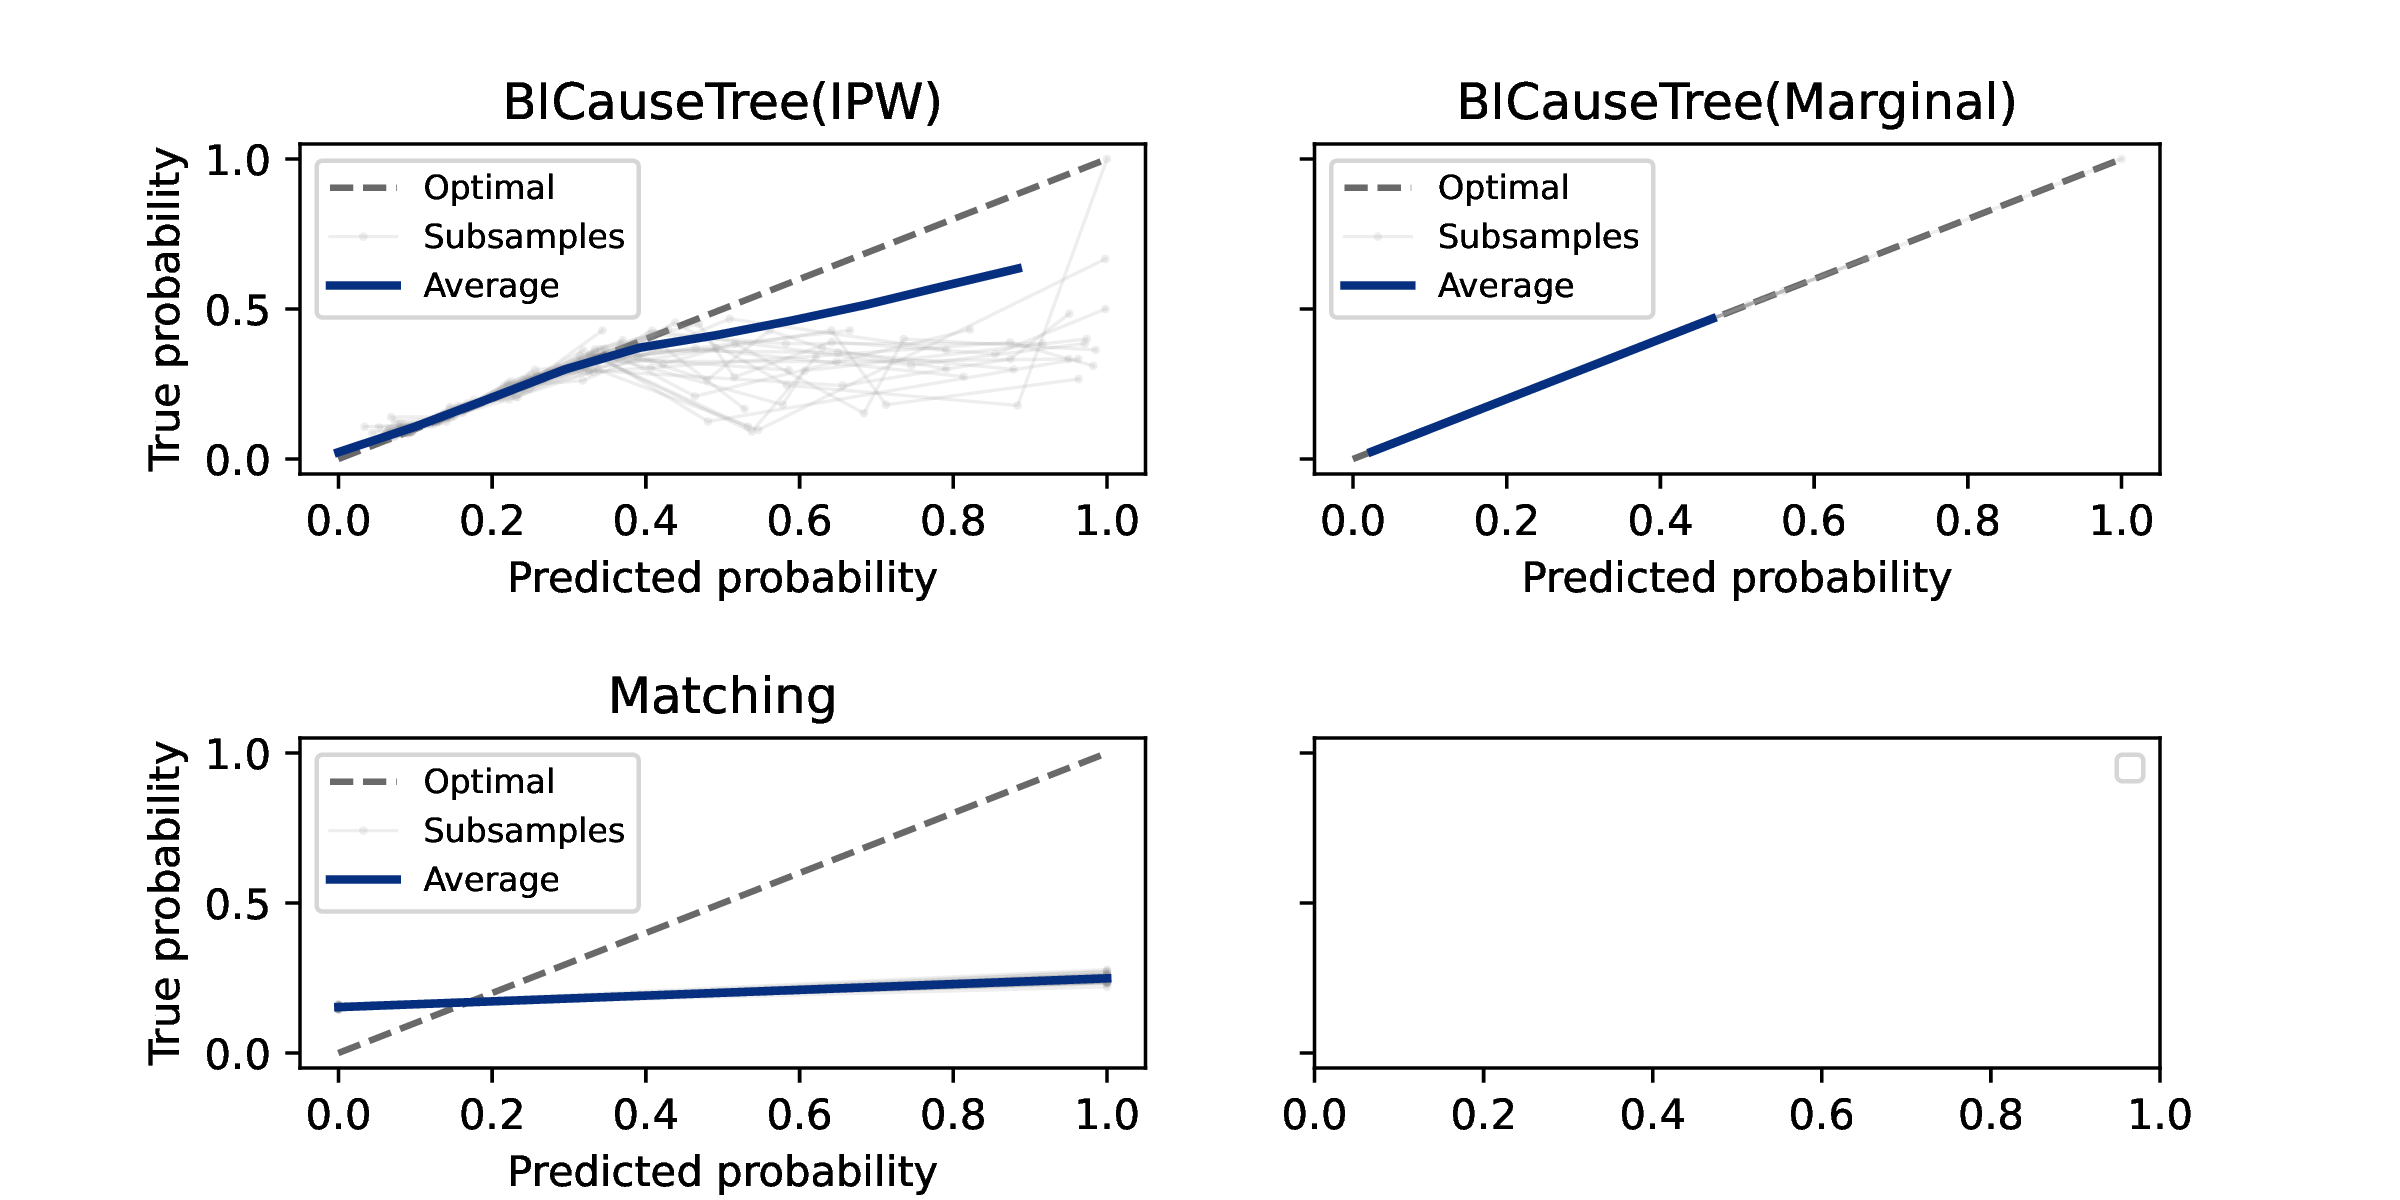

In [38]:
bootstrap_outcomes = get_outcomes(x, t, bootstrap_matrix, outcome_fitted_models, y)  # test only
filtered_bootstrap_outcomes = filter_results_by_positivity_violation(positivity_boot_mask, bootstrap_outcomes)
avg_smoothed_calibration_curves_y, calibration_curves_y = generate_calibration_data2(filtered_bootstrap_outcomes, y, 'y', t=t, n_bins=10)
fig_outcomes = plot_calibration_curve_2(avg_smoothed_calibration_curves_y, calibration_curves_y, use_legend=True)

Tree consistency

In [41]:
rand_scores, jaccard_scores = compute_jaccard_rand_score(x, bootstrap_matrix, tree_fitted_models, path=None)
print('Average Rand index and its standard deviation are equal to : ' + str(rand_scores))

Average Rand index and its standard deviation are equal to : (0.633, 0.208)


Bias across tree depths

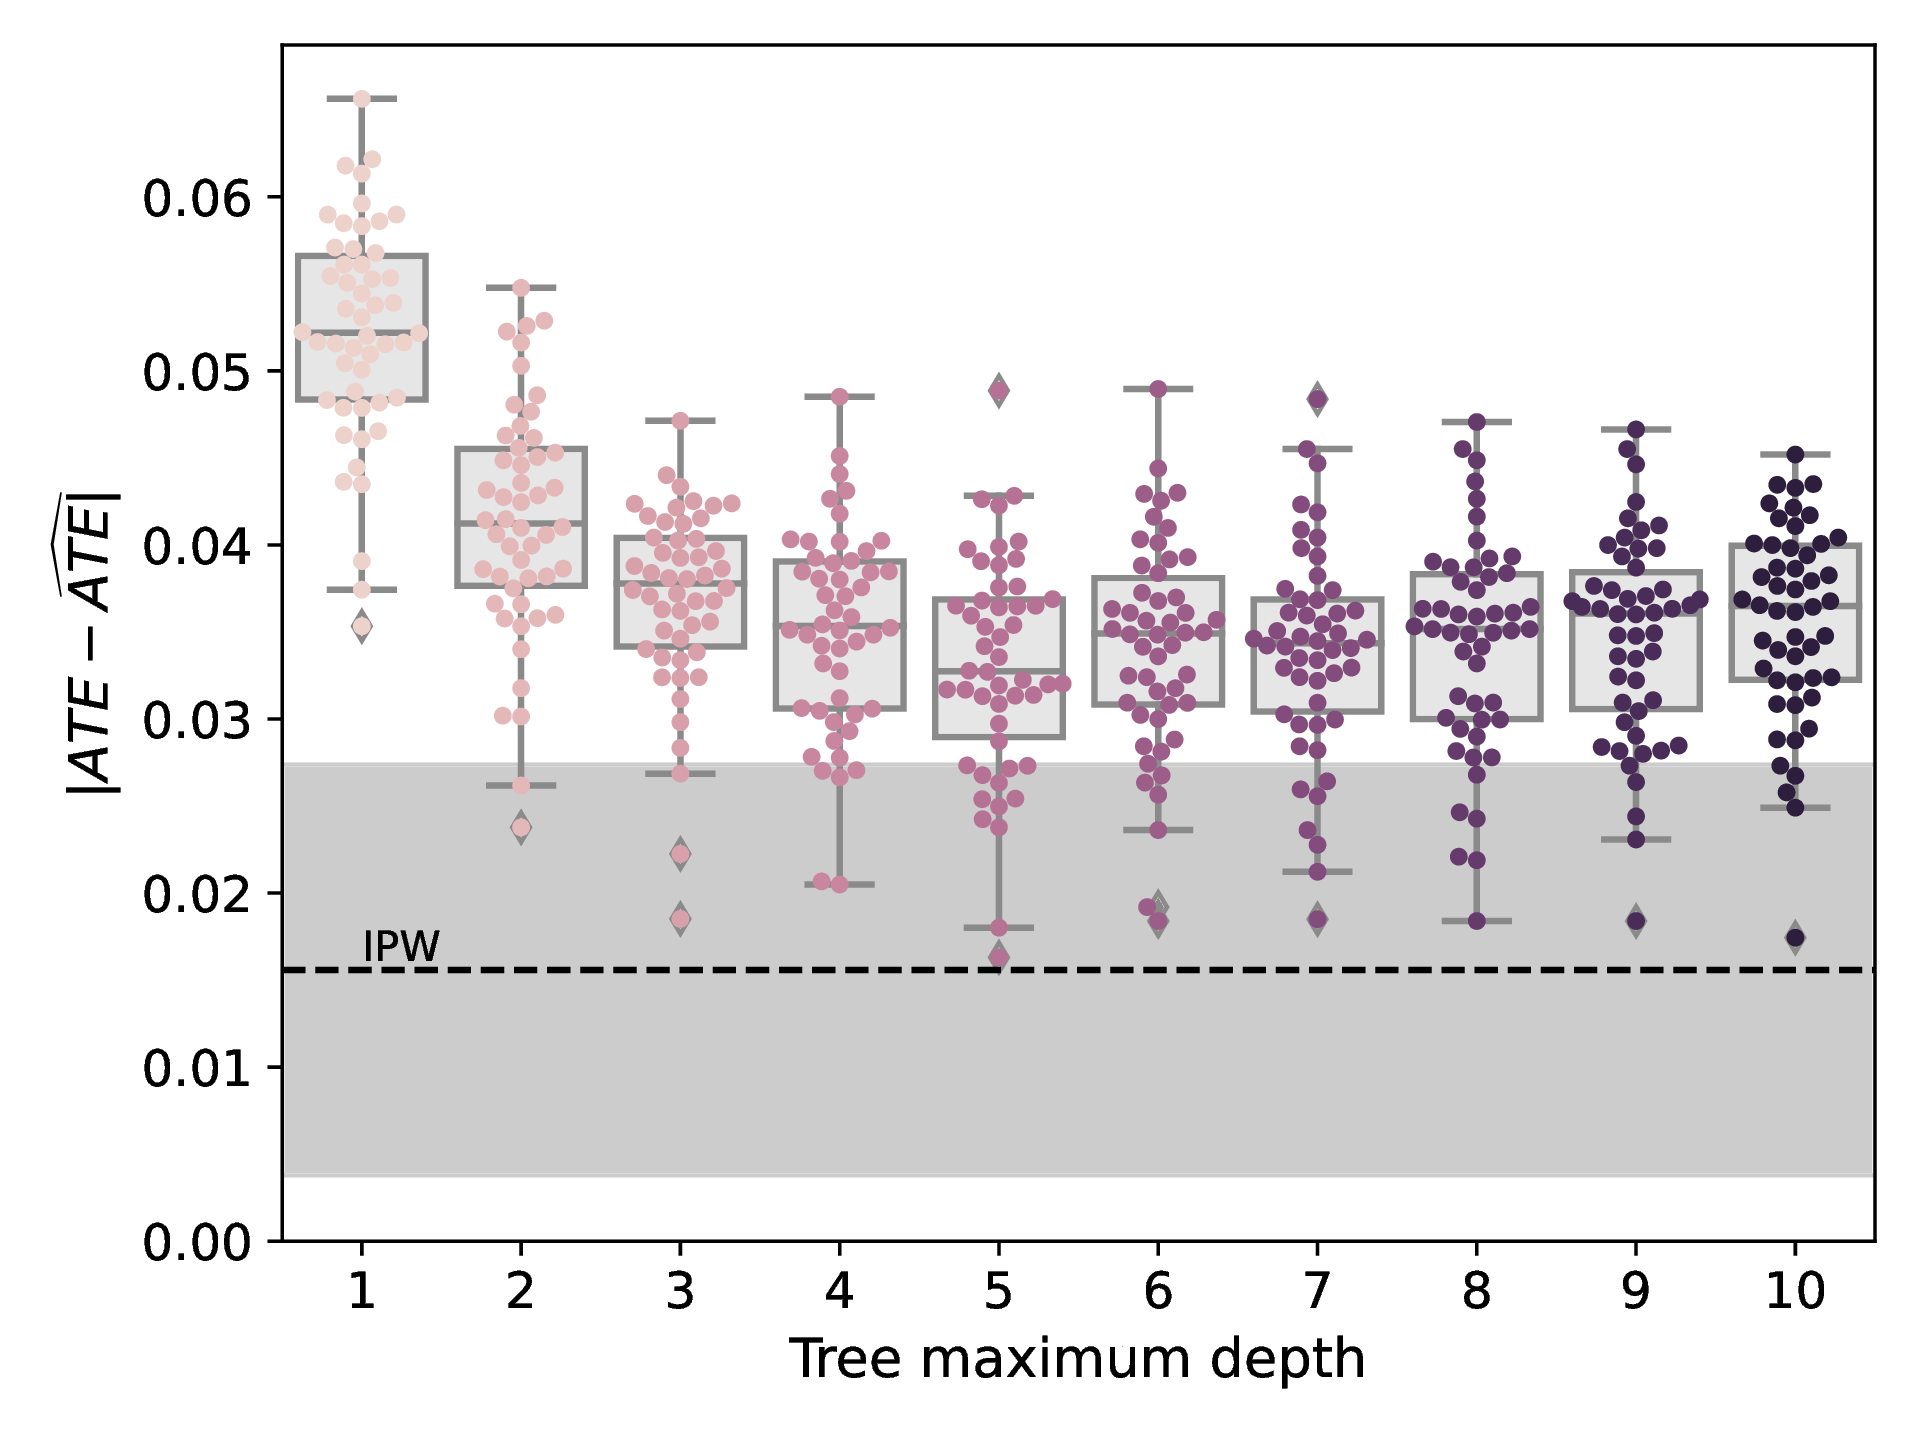

In [37]:
ipw_bias = generate_bias(x, t, y, data['y1'], data['y0'], bootstrap_matrix,
        IPW(LogisticRegression(penalty="none", max_iter=500)),
        on_train=True)

bias = generate_bias_across_depth(x, t, y, data['y1'], data['y0'], bootstrap_matrix,
                                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], n_feat_to_plot=10, on_train=True, path=None)
bias_fig = bias_plot_across_depth2(bias, ipw_bias, path=None)

ASMD across tree depths

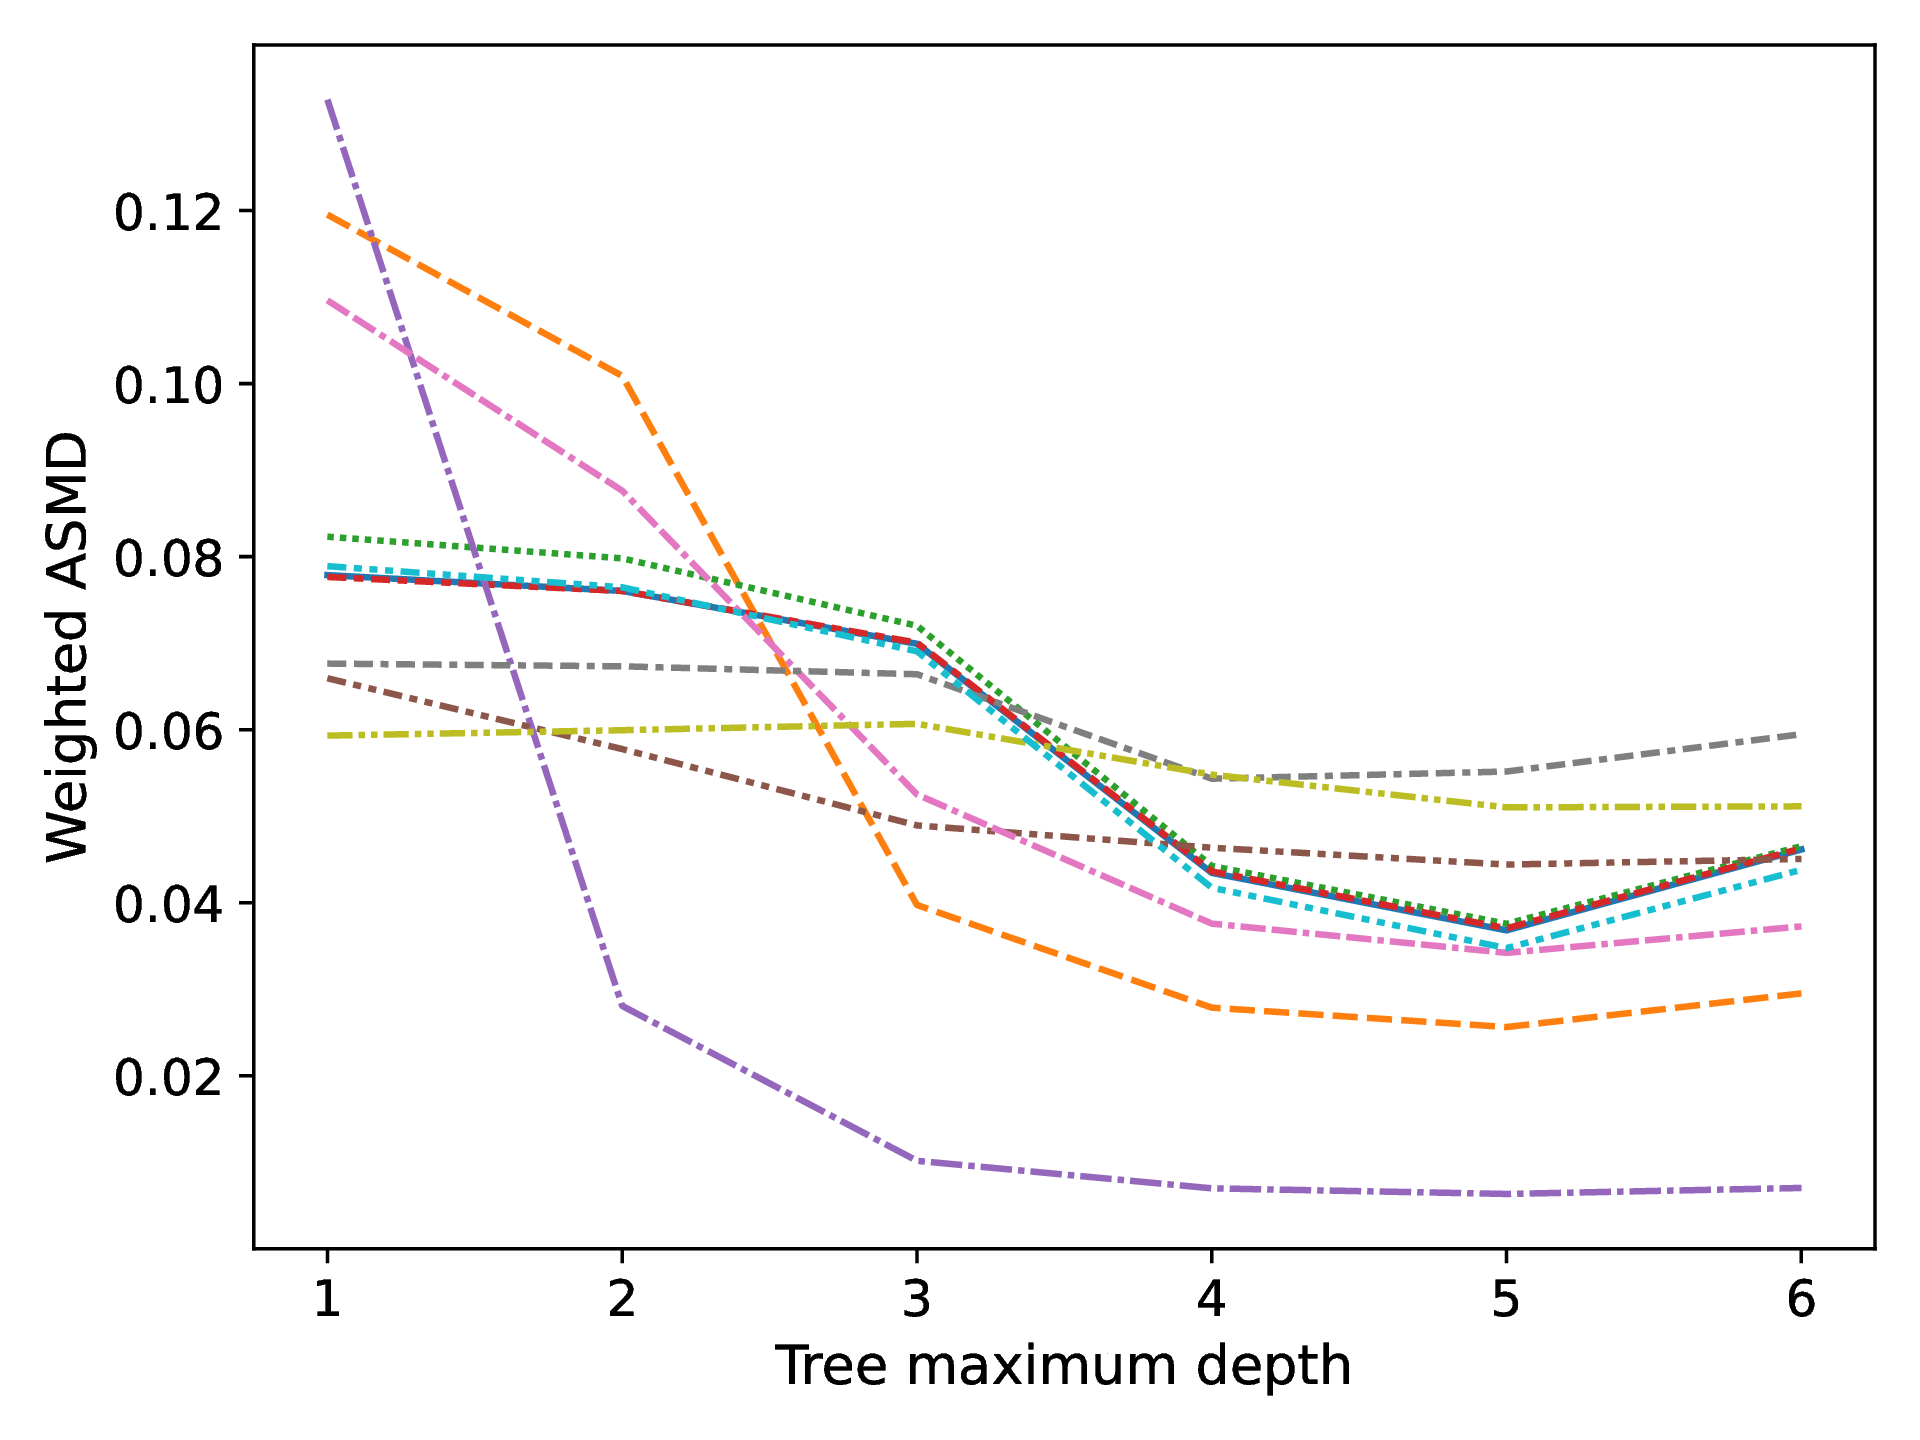

In [36]:
weighted_asmds, features_to_plot = generate_weighted_asmds_across_depths(x, t, bootstrap_matrix,
                                [1, 2, 3, 4, 5, 6], path= None)
asmd_fig = love_plot_across_depths(x, t, bootstrap_matrix, [1, 2, 3, 4, 5, 6], weighted_asmds, features_to_plot, path=None)

Plot tree on entire dataset

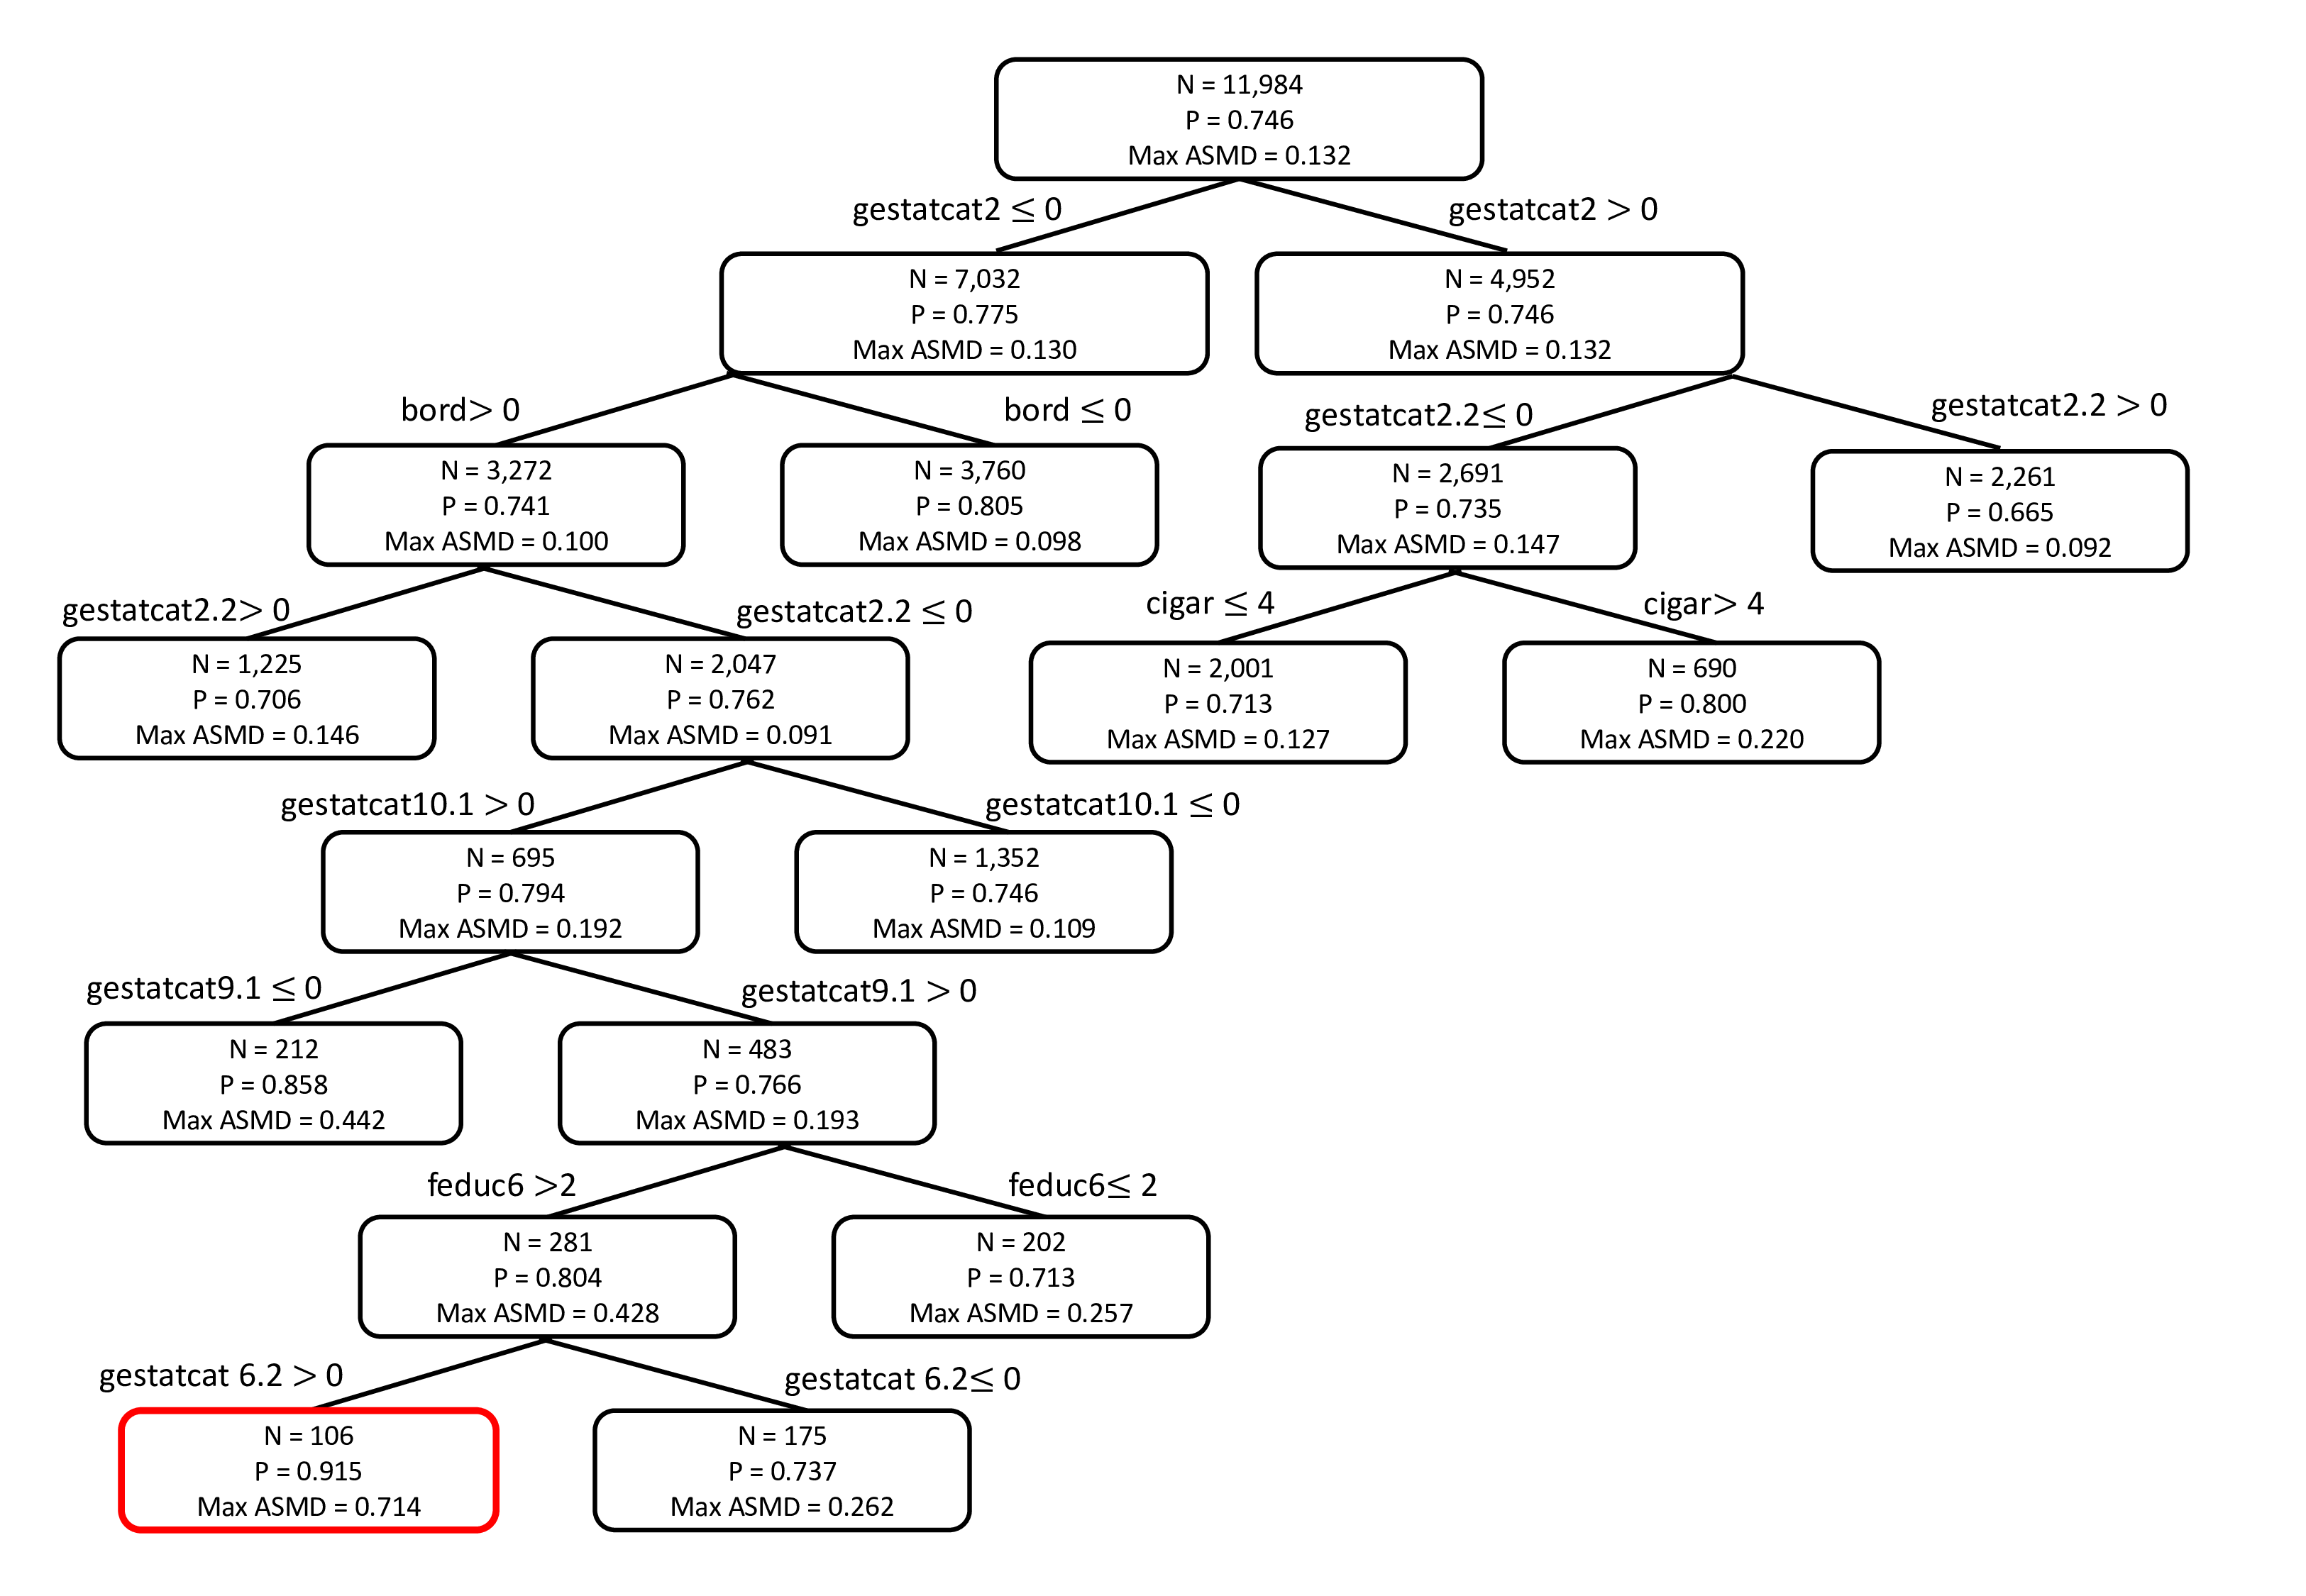

In [34]:
entire_fitted_model = {"BICauseTree(Marginal)": BICauseTree(min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
                                          individual=False,
                                          multiple_hypothesis_test_alpha=0.05,
                                          multiple_hypothesis_test_method=multiple_hypothesis_test_method,
                                          positivity_filtering_method=positivity_filtering_method,
                                          positivity_filtering_kwargs=positivity_filtering_kwargs,
                                          outcome_model=MarginalOutcomeEstimator(learner=None)
                                          )}
entire_fitted_model["BICauseTree(Marginal)"].fit(x, t, y)
save_tree_explains = save_tree_explains(x, t, entire_fitted_model, path=None)